In [46]:
!nvidia-smi

Mon May 29 09:07:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    48W / 400W |  25593MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/dome272/wuerstchen/
%cd wuerstchen
!wget https://huggingface.co/dome272/wuerstchen/resolve/main/model_stage_b.pt
!wget https://huggingface.co/dome272/wuerstchen/resolve/main/model_stage_c.pt
!wget https://huggingface.co/dome272/wuerstchen/raw/main/vqgan_f4_v1_500k.pt

!mkdir models
!mv -t models model_stage_b.pt model_stage_c.pt vqgan_f4_v1_500k.pt

!pip install transformers git+https://github.com/pabloppp/pytorch-tools

In [23]:
import os
import time
import torch
import torchvision
from PIL import Image
from vqgan import VQModel
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, T5EncoderModel, CLIPTextModel
from torch.utils.data import DataLoader
from modules import Paella, EfficientNetEncoder, Prior
from diffuzz import Diffuzz
import transformers
transformers.utils.logging.set_verbosity_error()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def showimages(imgs, rows=False, **kwargs):
    plt.figure(figsize=(kwargs.get("width", 32), kwargs.get("height", 32)))
    plt.axis("off")
    if rows:
        plt.imshow(torch.cat([torch.cat([i for i in row], dim=-1) for row in imgs], dim=-2).permute(1, 2, 0).cpu())
    else:
        plt.imshow(torch.cat([torch.cat([i for i in imgs], dim=-1)], dim=-2).permute(1, 2, 0).cpu())
    plt.show()

Using device: cuda:0


In [24]:
def sample(model, model_inputs, latent_shape, unconditional_inputs=None, init_x=None, steps=12, renoise_steps=None, temperature = (0.7, 0.3), cfg=(8.0, 8.0), mode = 'multinomial', t_start=1.0, t_end=0.0, sampling_conditional_steps=None, sampling_quant_steps=None, attn_weights=None): # 'quant', 'multinomial', 'argmax'
    device = unconditional_inputs["byt5"].device
    if sampling_conditional_steps is None:
        sampling_conditional_steps = steps
    if sampling_quant_steps is None:
        sampling_quant_steps = steps
    if renoise_steps is None:
        renoise_steps = steps-1
    if unconditional_inputs is None:
        unconditional_inputs = {k: torch.zeros_like(v) for k, v in model_inputs.items()}
    intermediate_images = []
    # with torch.inference_mode():
    init_noise = torch.randint(0, model.num_labels, size=latent_shape, device=device)
    if init_x != None:
        sampled = init_x
    else:
        sampled = init_noise.clone()
    t_list = torch.linspace(t_start, t_end, steps+1)
    temperatures = torch.linspace(temperature[0], temperature[1], steps)
    cfgs = torch.linspace(cfg[0], cfg[1], steps)
    if cfg is not None:
        model_inputs = {k:torch.cat([v, v_u]) for (k, v), (k_u, v_u) in zip(model_inputs.items(), unconditional_inputs.items())}
    for i, tv in enumerate(t_list[:steps]):
        if i >= sampling_quant_steps:
            mode = "quant"
        t = torch.ones(latent_shape[0], device=device) * tv

        if cfg is not None and i < sampling_conditional_steps:
            logits, uncond_logits = model(torch.cat([sampled]*2), torch.cat([t]*2), **model_inputs).chunk(2)
            logits = logits * cfgs[i] + uncond_logits * (1-cfgs[i])
        else:
            logits = model(sampled, t, **model_inputs)

        scores = logits.div(temperatures[i]).softmax(dim=1)

        if mode == 'argmax':
            sampled = logits.argmax(dim=1)
        elif mode == 'multinomial':
            sampled = scores.permute(0, 2, 3, 1).reshape(-1, logits.size(1))
            sampled = torch.multinomial(sampled, 1)[:, 0].view(logits.size(0), *logits.shape[2:])
        elif mode == 'quant':
            sampled = scores.permute(0, 2, 3, 1) @ vqmodel.vquantizer.codebook.weight.data
            sampled = vqmodel.vquantizer.forward(sampled, dim=-1)[-1]
        else:
            raise Exception(f"Mode '{mode}' not supported, use: 'quant', 'multinomial' or 'argmax'")

        intermediate_images.append(sampled)

        if i < renoise_steps:
            t_next = torch.ones(latent_shape[0], device=device) * t_list[i+1]
            sampled = model.add_noise(sampled, t_next, random_x=init_noise)[0]
            intermediate_images.append(sampled)
    return sampled, intermediate_images

## Load models

In [ ]:
effnet_preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(384, interpolation=torchvision.transforms.InterpolationMode.BILINEAR, antialias=True),
    torchvision.transforms.CenterCrop(384),
    torchvision.transforms.Normalize(
        mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    )
])

def encode(x):
    return vqmodel.encode(x, quantize=True)[2]
    
def decode(img_seq):
    return vqmodel.decode_indices(img_seq)
        
def embed_clip(caption, negative_caption="", batch_size=4, device="cuda"):
    clip_tokens = clip_tokenizer([caption] * batch_size, truncation=True, padding="max_length", max_length=clip_tokenizer.model_max_length, return_tensors="pt").to(device)
    clip_text_embeddings = clip_model(**clip_tokens).last_hidden_state

    clip_tokens_uncond = clip_tokenizer([negative_caption] * batch_size, truncation=True, padding="max_length", max_length=clip_tokenizer.model_max_length, return_tensors="pt").to(device)
    clip_text_embeddings_uncond = clip_model(**clip_tokens_uncond).last_hidden_state
    return clip_text_embeddings, clip_text_embeddings_uncond

vqmodel = VQModel().to(device)
vqmodel.load_state_dict(torch.load("models/vqgan_f4.pt", map_location=device))
vqmodel.eval().requires_grad_(False)

clip_model = CLIPTextModel.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K").to(device).eval().requires_grad_(False)
clip_tokenizer = AutoTokenizer.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")

pretrained_checkpoint = torch.load("models/model_stage_b.pt", map_location=device)

effnet = EfficientNetEncoder(effnet="efficientnet_v2_l").to(device)
effnet.load_state_dict(pretrained_checkpoint['effnet_state_dict'])
effnet.eval().requires_grad_(False)

diffuzz = Diffuzz(device=device)

# - Paella Model as generator - 
generator = Paella(byt5_embd=1024).to(device)
generator.load_state_dict(pretrained_checkpoint['state_dict'])
generator.eval().requires_grad_(False)
del pretrained_checkpoint

checkpoint = torch.load("models/model_stage_c.pt", map_location=device)
model = Prior(c_in=16, c=1536, c_cond=1024, c_r=64, depth=32, nhead=24).to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval().requires_grad_(False)
del checkpoint

torch.cuda.empty_cache()

### Optional: Optimize Inference
Execute the following cell to get a further speed up in execution using torch.compile. The first execution will take about 2 minutes, as it finds the optimal compute graph. After that it should give > 2x speedup.

In [44]:
model = torch.compile(model, mode="reduce-overhead", fullgraph=True)
generator = torch.compile(generator, mode="reduce-overhead", fullgraph=True)

## Sampling

Prior Sampling: 1.4586429595947266


Generator Sampling: 1.556213140487671
Decoder Generation: 0.008175849914550781
Temperature: (1.0, 0.6), CFG: (2.0, 2.0), Steps: 8
Epic drawing of a dog


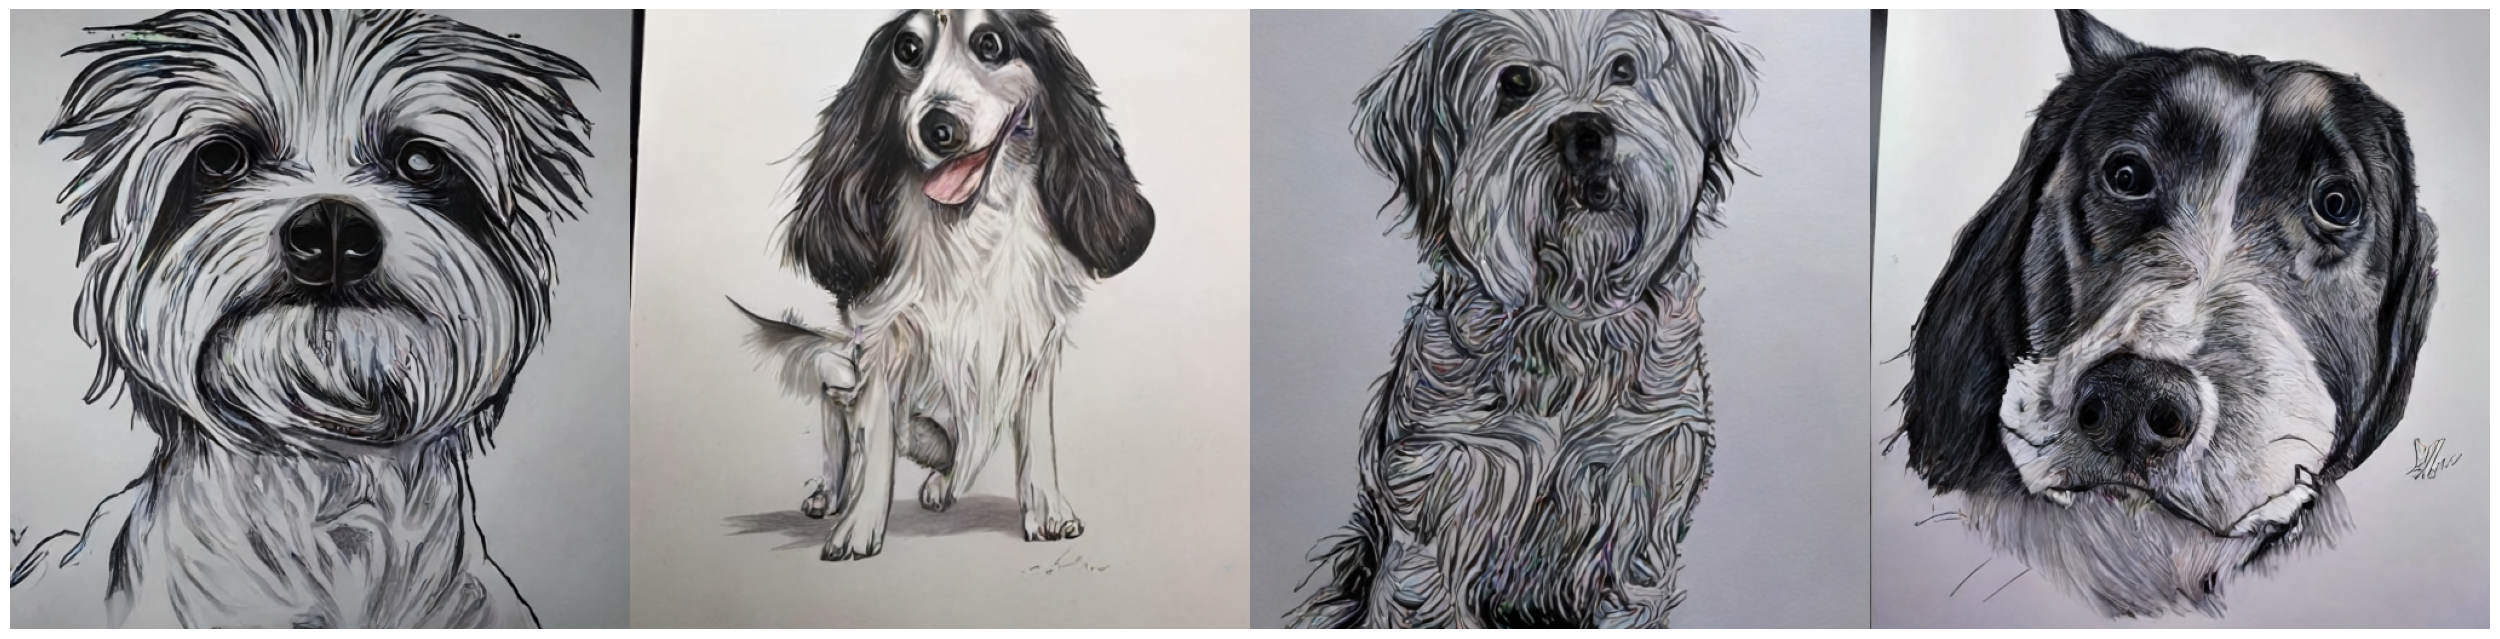

In [47]:
batch_size = 4
caption = "Epic drawing of a dog"
negative_caption = "low resolution, low detail, bad quality, blurry"
# negative_caption = ""
prior_timesteps = 60
prior_cfg = 6
prior_sampler = "ddpm"

clip_text_embeddings, clip_text_embeddings_uncond = embed_clip(caption, negative_caption, batch_size, device)

effnet_features_shape = (batch_size, 16, 12, 12)
effnet_embeddings_uncond = torch.zeros(effnet_features_shape).to(device)
generator_latent_shape = (batch_size, 128, 128)
# torch.manual_seed(42)
with torch.cuda.amp.autocast(dtype=torch.bfloat16), torch.no_grad():
    s = time.time()
    sampled = diffuzz.sample(model, {'c': clip_text_embeddings}, unconditional_inputs={"c": clip_text_embeddings_uncond}, shape=effnet_features_shape,
                            timesteps=prior_timesteps, cfg=prior_cfg, sampler=prior_sampler,
                            t_start=1.0)[-1]
    print(f"Prior Sampling: {time.time() - s}")
    temperature, cfg, steps =(1.0, 0.6), (2.0, 2.0), 8
    s = time.time()
    sampled_images_original, intermediate = sample(
        generator, {'effnet': sampled,'byt5': clip_text_embeddings}, generator_latent_shape, unconditional_inputs = {'effnet': effnet_embeddings_uncond, 'byt5': clip_text_embeddings_uncond},
        temperature=temperature, cfg=cfg, steps=steps
    )
    print(f"Generator Sampling: {time.time() - s}")

s = time.time()
sampled = decode(sampled_images_original)
print(f"Decoder Generation: {time.time() - s}")
# intermediate = [decode(i) for i in intermediate]
print(f"Temperature: {temperature}, CFG: {cfg}, Steps: {steps}")
print(caption)
showimages(sampled)
# showimages(intermediate, rows=True)